In [71]:
import numpy
# scipy.special für die Sigmoid-Funktion expit()
import scipy.special
# Bibliothek zum Plotten von Arrays
import matplotlib.pyplot as plt
# sicherstellen, dass die Plots in diesem Notebook und nicht in einem externen Fenster angezeigt werden
%matplotlib inline

In [72]:
# Definition der neuronalen Netzwerkklasse
class neuralNetwork:

    # Initialisierung des neuronalen Netzwerks
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # Anzahl der Nodes in jeder Input-, hidden und output layer festlegen
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes

        # Gewichtsmatrizen, wih und who
        self.wih = numpy.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))

        # Lernrate
        self.lr = learningrate

        # Aktivierungsfunktion ist die Sigmoid-Funktion
        self.activation_function = lambda x: scipy.special.expit(x)

        pass

    # Trainieren des neuronalen Netzwerks
    def train(self, inputs_list, targets_list):
        # Inputs in ein 2D-Array umwandeln
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(targets_list, ndmin=2).T

        # Signale in dem Hidden Layer berechnen
        hidden_inputs = numpy.dot(self.wih, inputs)
        # Signale berechnen, die aus dem Hidden Layer hervorgehen
        hidden_outputs = self.activation_function(hidden_inputs)

        # Signale in dem endgültigen Output Layer berechnen
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # Signale berechnen, die aus dem endgültigen Output Layer  hervorgehen
        final_outputs = self.activation_function(final_inputs)

        # Fehler in dem Output Layer ist (Ziel - Ist)
        output_errors = targets - final_outputs
        # Fehler in dem Hidden Layer ist der output_errors, aufgeteilt nach Gewichten, neu kombiniert an den Hidden Nodes
        hidden_errors = numpy.dot(self.who.T, output_errors)

        # Gewichte für die Verbindungen zwischen den hidden und den Output Layers aktualisieren
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))

        # Gewichte für die Verbindungen zwischen den Input- und den Hidden Layern aktualisieren
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))

        pass

    # Abfragen des neuronalen Netzwerks
    def query(self, inputs_list):
        # Input List in ein 2D-Array umwandeln
        inputs = numpy.array(inputs_list, ndmin=2).T

        # Signale in die Hidden Layern berechnen
        hidden_inputs = numpy.dot(self.wih, inputs)
        # Signale berechnen, die aus dem Hidden Layer hervorgehen
        hidden_outputs = self.activation_function(hidden_inputs)

        # Signale in den endgültigen Output Layer berechnen
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # Signale berechnen, die aus dem endgültigen Output Layer hervorgehen
        final_outputs = self.activation_function(final_inputs)

        return final_outputs

In [73]:
# Anzahl an input, hidden und output nodes
input_nodes = 784
hidden_nodes = 15
output_nodes = 1

# Lernrate
learning_rate = 0.05

# Erstelle Instanz des neuronalen Netzwerks
n = neuralNetwork(input_nodes,hidden_nodes,output_nodes, learning_rate)

In [74]:
with open("../data/fashion-mnist_train.csv", 'r') as training_data_file:
    training_data_list = training_data_file.readlines()[1:]

In [75]:
with open("../data/fashion-mnist_test.csv", 'r') as test_data_file:
    test_data_list = test_data_file.readlines()[1:]

In [76]:
# Epochen ist die Anzahl der Male, die der Trainingsdatensatz zum Training verwendet wird
epochs = 10

# Erstellen Sie eine Liste von 10 Ensembles, die jeweils 10 Modelle enthalten
ensembles = []
for _ in range(10):
    ensemble = []
    for i in range(10):
        ensemble.append(neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate))
    ensembles.append(ensemble)

In [77]:
for ensemble in ensembles:
    for i in range(10):
        for e in range(epochs):
            for record in training_data_list:
                all_values = record.split(',')
                inputs = (numpy.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
                target = numpy.array([0.99 if int(all_values[0]) == i else 0.01])
                ensemble[i].train(inputs, target)

In [78]:
# Initialize lists to store performance metrics
scorecard = []
test_confidences = []

# Go through all the records in the test data set
for record in test_data_list:
    all_values = record.split(',')
    if len(all_values) != 785:  # Skip invalid records
        continue
        
    # Correct answer is first value
    correct_label = int(all_values[0])
    inputs = (numpy.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
    
    # Get predictions from all models in all ensembles
    ensemble_predictions = []
    for ensemble in ensembles:
        outputs = [model.query(inputs) for model in ensemble]
        predicted_labels = [i for i, output in enumerate(outputs) if output[0] > 0.5]
        ensemble_predictions.extend(predicted_labels)
    
    if ensemble_predictions:
        # Get the most common prediction
        prediction = max(set(ensemble_predictions), key=ensemble_predictions.count)
        # Calculate confidence (number of votes for the prediction / total votes)
        confidence = ensemble_predictions.count(prediction) / len(ensemble_predictions)
        test_confidences.append(confidence)
        
        # Append 1 to scorecard for correct prediction, 0 for incorrect
        scorecard.append(1 if prediction == correct_label else 0)
    else:
        # Handle the case when no predictions were made
        test_confidences.append(0.0)  # Record zero confidence
        scorecard.append(0)  # Count as incorrect prediction

# Calculate the performance score
score = sum(scorecard) / len(scorecard)
print(f'Performance = {score}')

# Calculate average confidence
avg_confidence = sum(test_confidences) / len(test_confidences)
print(f'Average confidence = {avg_confidence:.4f}')

Performance = 0.8732
Average confidence = 0.9468


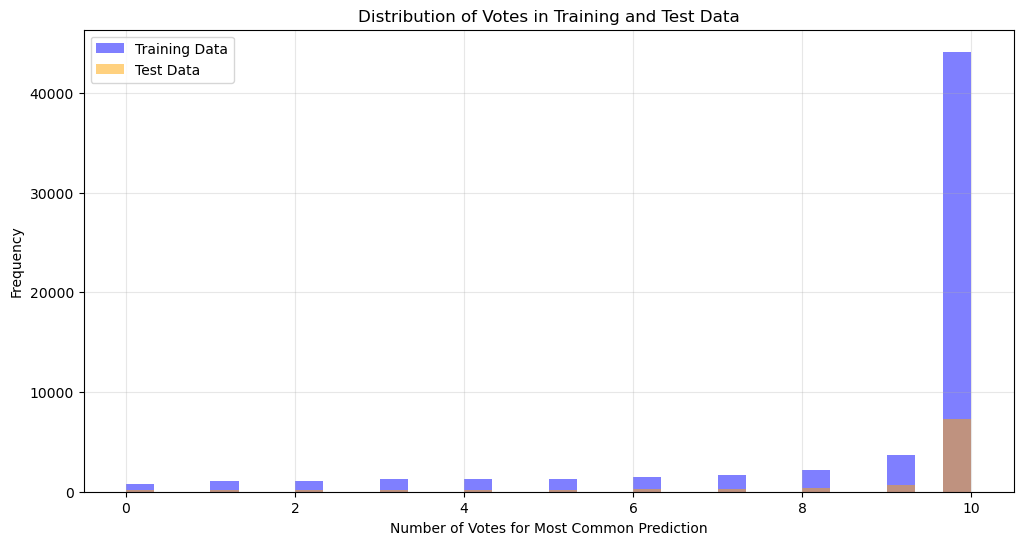

Average votes in training data: 8.86
Average votes in test data: 8.82


In [79]:
# Initialize lists to store vote counts
train_vote_counts = []
test_vote_counts = []

# Analyze training data
for record in training_data_list:
    all_values = record.split(',')
    if len(all_values) != 785:  # Skip invalid records
        continue
        
    correct_label = int(all_values[0])
    inputs = (numpy.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
    
    # Collect votes from all models in all ensembles
    ensemble_predictions = []
    for ensemble in ensembles:
        outputs = [model.query(inputs) for model in ensemble]
        predicted_labels = [i for i, output in enumerate(outputs) if output[0] > 0.5]
        ensemble_predictions.extend(predicted_labels)
    
    if ensemble_predictions:
        most_common = max(set(ensemble_predictions), key=ensemble_predictions.count)
        votes = ensemble_predictions.count(most_common)
        train_vote_counts.append(votes)
    else:
        train_vote_counts.append(0)  # Add zero votes when no predictions are made
        

# Analyze test data
for record in test_data_list:
    all_values = record.split(',')
    if len(all_values) != 785:  # Skip invalid records
        continue
        
    correct_label = int(all_values[0])
    inputs = (numpy.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
    
    # Collect votes from all models in all ensembles
    ensemble_predictions = []
    for ensemble in ensembles:
        outputs = [model.query(inputs) for model in ensemble]
        predicted_labels = [i for i, output in enumerate(outputs) if output[0] > 0.5]
        ensemble_predictions.extend(predicted_labels)
    
    if ensemble_predictions:
        most_common = max(set(ensemble_predictions), key=ensemble_predictions.count)
        votes = ensemble_predictions.count(most_common)
        test_vote_counts.append(votes)
    else:
        test_vote_counts.append(0)  # Add zero votes when no predictions are made

# Visualize the distribution of votes
plt.figure(figsize=(12, 6))
plt.hist(train_vote_counts, bins=30, alpha=0.5, label='Training Data', color='blue')
plt.hist(test_vote_counts, bins=30, alpha=0.5, label='Test Data', color='orange')
plt.xlabel('Number of Votes for Most Common Prediction')
plt.ylabel('Frequency')
plt.title('Distribution of Votes in Training and Test Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print statistics
print(f'Average votes in training data: {numpy.mean(train_vote_counts):.2f}')
print(f'Average votes in test data: {numpy.mean(test_vote_counts):.2f}')

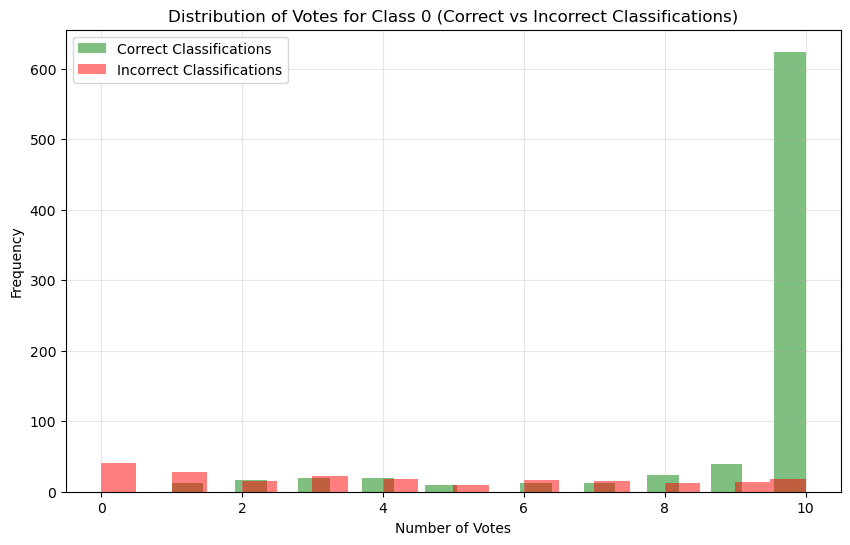

Average votes for correct classifications: 9.09
Average votes for incorrect classifications: 4.06


In [80]:
# Collect votes for class 0
correct_votes_0 = []
incorrect_votes_0 = []

# Go through all test data
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:  # Skip invalid records
        continue
        
    correct_label = int(all_values[0])
    
    # Only consider class 0
    if correct_label == 0:
        if score == 1:  # Correct classification
            correct_votes_0.append(votes)
        else:  # Incorrect classification
            incorrect_votes_0.append(votes)

# Create plot
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_0, bins=20, alpha=0.5, label='Correct Classifications', color='green')
plt.hist(incorrect_votes_0, bins=20, alpha=0.5, label='Incorrect Classifications', color='red')

plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Votes for Class 0 (Correct vs Incorrect Classifications)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print statistics
print(f'Average votes for correct classifications: {numpy.mean(correct_votes_0):.2f}')
print(f'Average votes for incorrect classifications: {numpy.mean(incorrect_votes_0):.2f}')

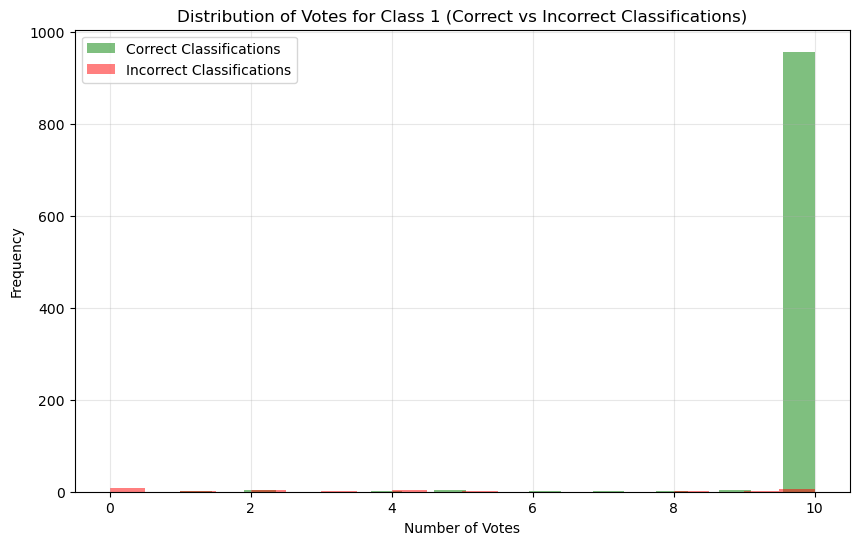

Average votes for correct classifications: 9.92
Average votes for incorrect classifications: 3.96


In [81]:
# Collect votes for class 1
correct_votes = []
incorrect_votes = []

# Go through all test data
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:  # Skip invalid records
        continue
        
    correct_label = int(all_values[0])
    
    # Only consider class 1
    if correct_label == 1:
        if score == 1:  # Correct classification
            correct_votes.append(votes)
        else:  # Incorrect classification
            incorrect_votes.append(votes)

# Create plot
plt.figure(figsize=(10, 6))
plt.hist(correct_votes, bins=20, alpha=0.5, label='Correct Classifications', color='green')
plt.hist(incorrect_votes, bins=20, alpha=0.5, label='Incorrect Classifications', color='red')

plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Votes for Class 1 (Correct vs Incorrect Classifications)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print statistics
print(f'Average votes for correct classifications: {numpy.mean(correct_votes):.2f}')
print(f'Average votes for incorrect classifications: {numpy.mean(incorrect_votes):.2f}')

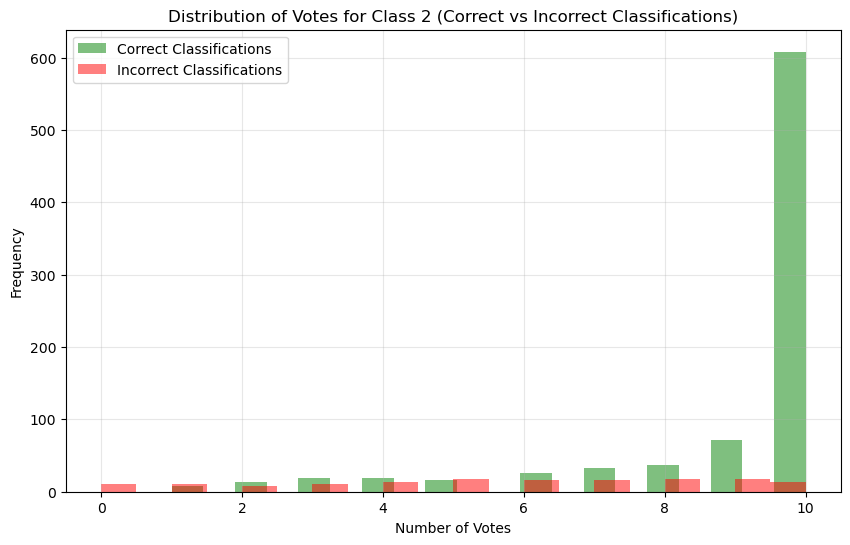

Average votes for correct classifications: 9.00
Average votes for incorrect classifications: 5.59


In [82]:
# Collect votes for class 2
correct_votes_2 = []
incorrect_votes_2 = []

# Go through all test data
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:  # Skip invalid records
        continue
        
    correct_label = int(all_values[0])
    
    # Only consider class 2
    if correct_label == 2:
        if score == 1:  # Correct classification
            correct_votes_2.append(votes)
        else:  # Incorrect classification
            incorrect_votes_2.append(votes)

# Create plot
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_2, bins=20, alpha=0.5, label='Correct Classifications', color='green')
plt.hist(incorrect_votes_2, bins=20, alpha=0.5, label='Incorrect Classifications', color='red')

plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Votes for Class 2 (Correct vs Incorrect Classifications)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print statistics
print(f'Average votes for correct classifications: {numpy.mean(correct_votes_2):.2f}')
print(f'Average votes for incorrect classifications: {numpy.mean(incorrect_votes_2):.2f}')

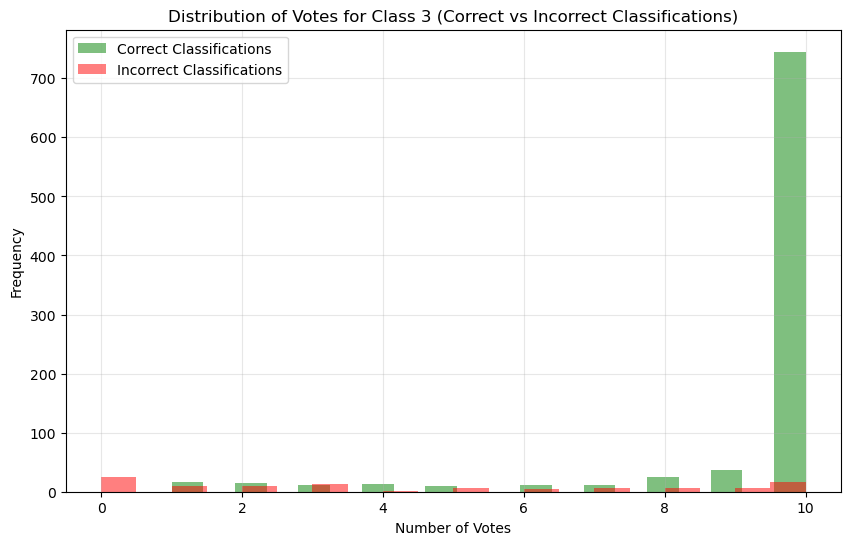

Average votes for correct classifications: 9.29
Average votes for incorrect classifications: 4.34


In [83]:
# Collect votes for class 3
correct_votes_3 = []
incorrect_votes_3 = []

# Go through all test data
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:  # Skip invalid records
        continue
        
    correct_label = int(all_values[0])
    
    # Only consider class 3
    if correct_label == 3:
        if score == 1:  # Correct classification
            correct_votes_3.append(votes)
        else:  # Incorrect classification
            incorrect_votes_3.append(votes)

# Create plot
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_3, bins=20, alpha=0.5, label='Correct Classifications', color='green')
plt.hist(incorrect_votes_3, bins=20, alpha=0.5, label='Incorrect Classifications', color='red')

plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Votes for Class 3 (Correct vs Incorrect Classifications)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print statistics
print(f'Average votes for correct classifications: {numpy.mean(correct_votes_3):.2f}')
print(f'Average votes for incorrect classifications: {numpy.mean(incorrect_votes_3):.2f}')

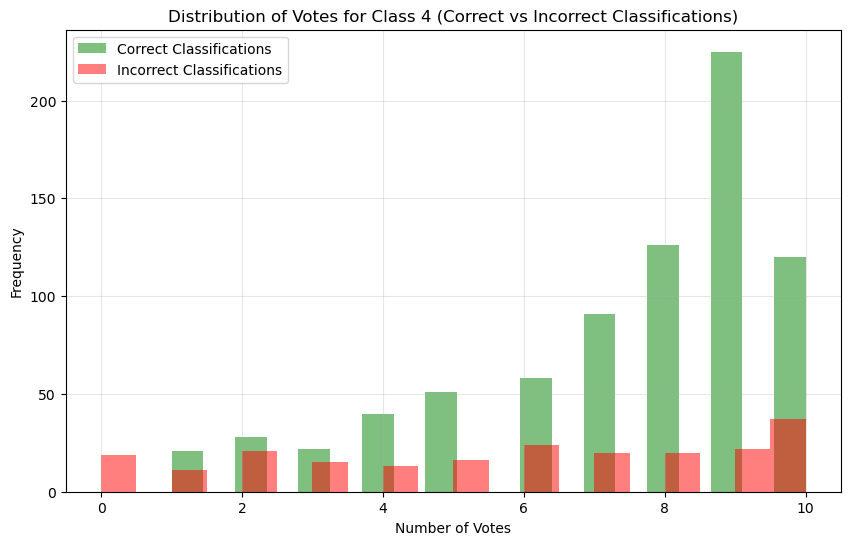

Average votes for correct classifications: 7.39
Average votes for incorrect classifications: 5.70


In [84]:
# Collect votes for class 4
correct_votes_4 = []
incorrect_votes_4 = []

# Go through all test data
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:  # Skip invalid records
        continue
        
    correct_label = int(all_values[0])
    
    # Only consider class 4
    if correct_label == 4:
        if score == 1:  # Correct classification
            correct_votes_4.append(votes)
        else:  # Incorrect classification
            incorrect_votes_4.append(votes)

# Create plot
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_4, bins=20, alpha=0.5, label='Correct Classifications', color='green')
plt.hist(incorrect_votes_4, bins=20, alpha=0.5, label='Incorrect Classifications', color='red')

plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Votes for Class 4 (Correct vs Incorrect Classifications)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print statistics
print(f'Average votes for correct classifications: {numpy.mean(correct_votes_4):.2f}')
print(f'Average votes for incorrect classifications: {numpy.mean(incorrect_votes_4):.2f}')

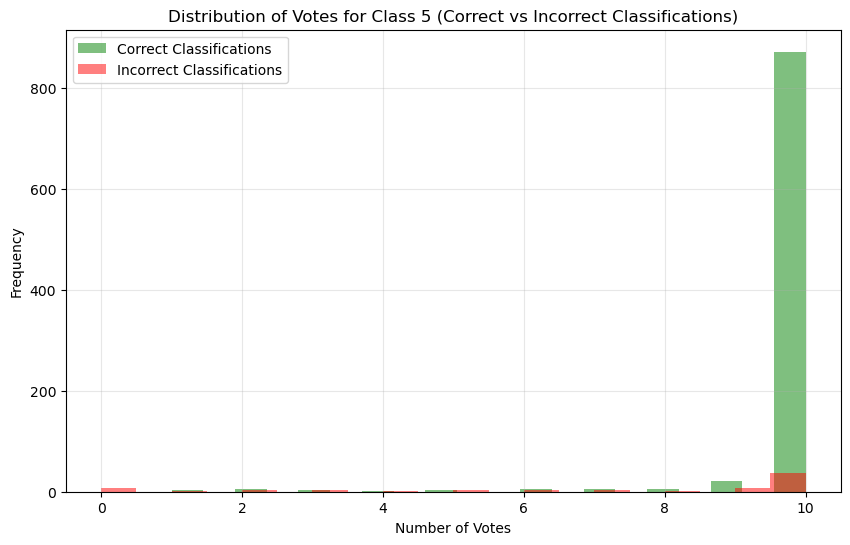

Average votes for correct classifications: 9.79
Average votes for incorrect classifications: 7.27


In [85]:
# Collect votes for class 5
correct_votes_5 = []
incorrect_votes_5 = []

# Go through all test data
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:  # Skip invalid records
        continue
        
    correct_label = int(all_values[0])
    
    # Only consider class 5
    if correct_label == 5:
        if score == 1:  # Correct classification
            correct_votes_5.append(votes)
        else:  # Incorrect classification
            incorrect_votes_5.append(votes)

# Create plot
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_5, bins=20, alpha=0.5, label='Correct Classifications', color='green')
plt.hist(incorrect_votes_5, bins=20, alpha=0.5, label='Incorrect Classifications', color='red')

plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Votes for Class 5 (Correct vs Incorrect Classifications)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print statistics
print(f'Average votes for correct classifications: {numpy.mean(correct_votes_5):.2f}')
print(f'Average votes for incorrect classifications: {numpy.mean(incorrect_votes_5):.2f}')

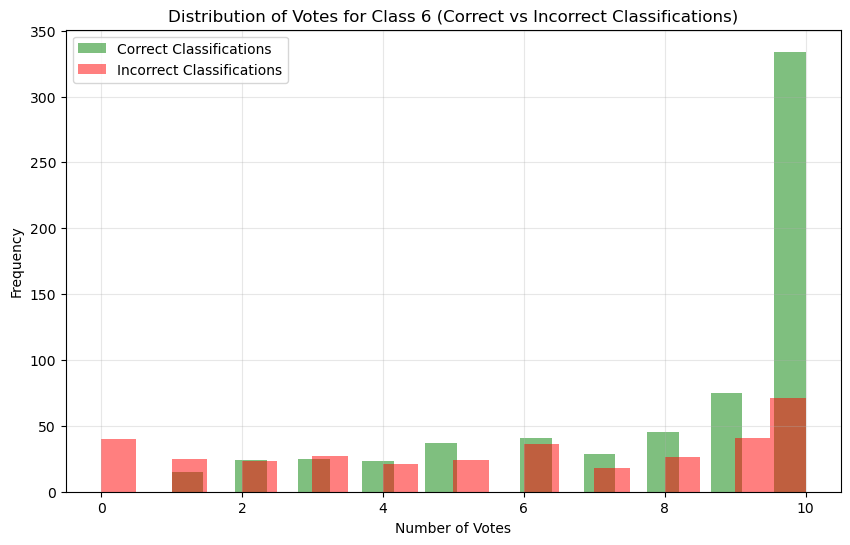

Average votes for correct classifications: 8.08
Average votes for incorrect classifications: 5.64


In [86]:
# Collect votes for class 6
correct_votes_6 = []
incorrect_votes_6 = []

# Go through all test data
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:  # Skip invalid records
        continue
        
    correct_label = int(all_values[0])
    
    # Only consider class 6
    if correct_label == 6:
        if score == 1:  # Correct classification
            correct_votes_6.append(votes)
        else:  # Incorrect classification
            incorrect_votes_6.append(votes)

# Create plot
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_6, bins=20, alpha=0.5, label='Correct Classifications', color='green')
plt.hist(incorrect_votes_6, bins=20, alpha=0.5, label='Incorrect Classifications', color='red')

plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Votes for Class 6 (Correct vs Incorrect Classifications)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print statistics
print(f'Average votes for correct classifications: {numpy.mean(correct_votes_6):.2f}')
print(f'Average votes for incorrect classifications: {numpy.mean(incorrect_votes_6):.2f}')

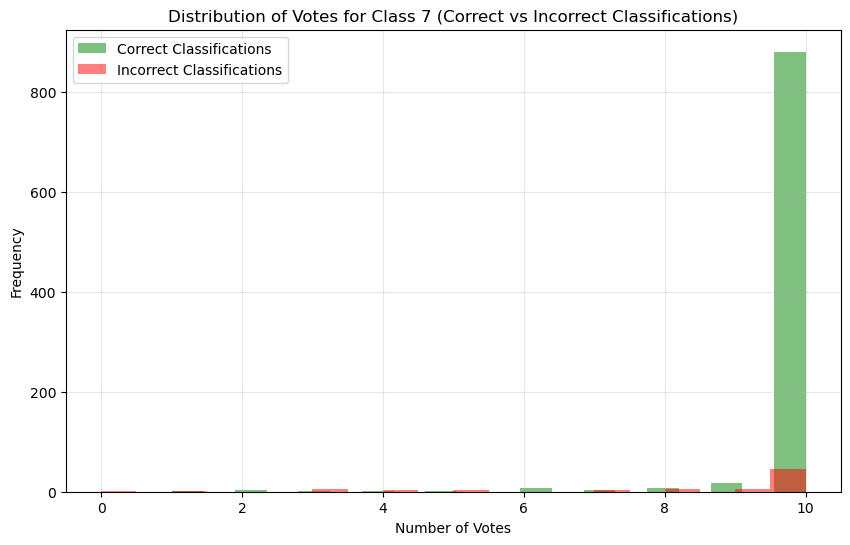

Average votes for correct classifications: 9.87
Average votes for incorrect classifications: 8.16


In [87]:
# Collect votes for class 7
correct_votes_7 = []
incorrect_votes_7 = []

# Go through all test data
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:  # Skip invalid records
        continue
        
    correct_label = int(all_values[0])
    
    # Only consider class 7
    if correct_label == 7:
        if score == 1:  # Correct classification
            correct_votes_7.append(votes)
        else:  # Incorrect classification
            incorrect_votes_7.append(votes)

# Create plot
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_7, bins=20, alpha=0.5, label='Correct Classifications', color='green')
plt.hist(incorrect_votes_7, bins=20, alpha=0.5, label='Incorrect Classifications', color='red')

plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Votes for Class 7 (Correct vs Incorrect Classifications)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print statistics
print(f'Average votes for correct classifications: {numpy.mean(correct_votes_7):.2f}')
print(f'Average votes for incorrect classifications: {numpy.mean(incorrect_votes_7):.2f}')

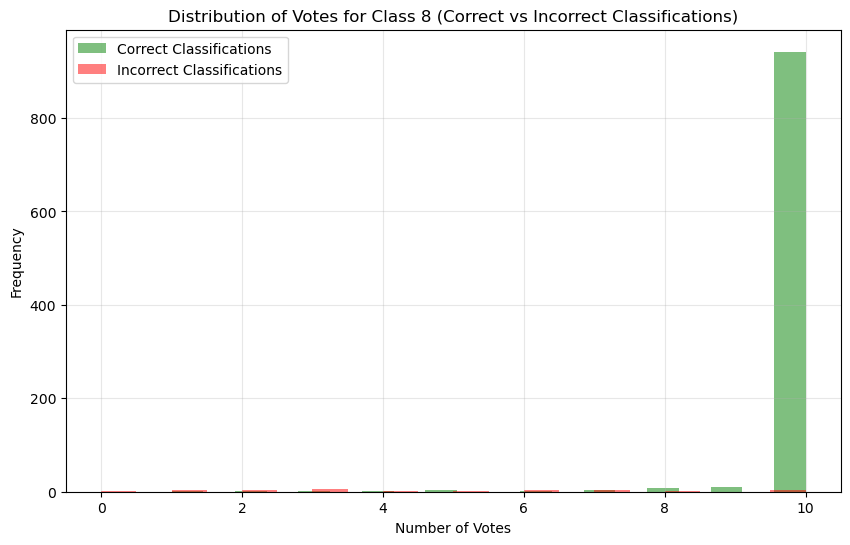

Average votes for correct classifications: 9.91
Average votes for incorrect classifications: 4.59


In [88]:
# Collect votes for class 8
correct_votes_8 = []
incorrect_votes_8 = []

# Go through all test data
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:  # Skip invalid records
        continue
        
    correct_label = int(all_values[0])
    
    # Only consider class 8
    if correct_label == 8:
        if score == 1:  # Correct classification
            correct_votes_8.append(votes)
        else:  # Incorrect classification
            incorrect_votes_8.append(votes)

# Create plot
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_8, bins=20, alpha=0.5, label='Correct Classifications', color='green')
plt.hist(incorrect_votes_8, bins=20, alpha=0.5, label='Incorrect Classifications', color='red')

plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Votes for Class 8 (Correct vs Incorrect Classifications)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print statistics
print(f'Average votes for correct classifications: {numpy.mean(correct_votes_8):.2f}')
print(f'Average votes for incorrect classifications: {numpy.mean(incorrect_votes_8):.2f}')

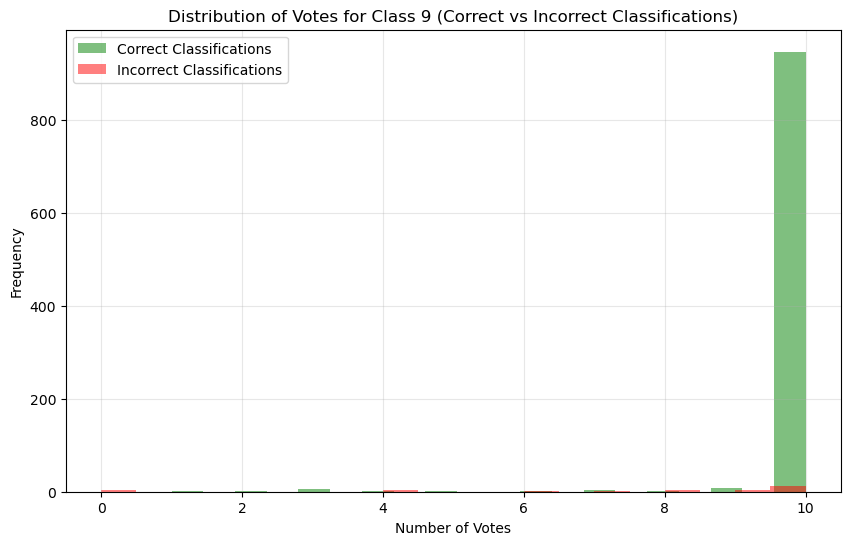

Average votes for correct classifications: 9.89
Average votes for incorrect classifications: 7.57


In [89]:
# Collect votes for class 9
correct_votes_9 = []
incorrect_votes_9 = []

# Go through all test data
for record, votes, score in zip(test_data_list, test_vote_counts, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:  # Skip invalid records
        continue
        
    correct_label = int(all_values[0])
    
    # Only consider class 9
    if correct_label == 9:
        if score == 1:  # Correct classification
            correct_votes_9.append(votes)
        else:  # Incorrect classification
            incorrect_votes_9.append(votes)

# Create plot
plt.figure(figsize=(10, 6))
plt.hist(correct_votes_9, bins=20, alpha=0.5, label='Correct Classifications', color='green')
plt.hist(incorrect_votes_9, bins=20, alpha=0.5, label='Incorrect Classifications', color='red')

plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Votes for Class 9 (Correct vs Incorrect Classifications)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print statistics
print(f'Average votes for correct classifications: {numpy.mean(correct_votes_9):.2f}')
print(f'Average votes for incorrect classifications: {numpy.mean(incorrect_votes_9):.2f}')

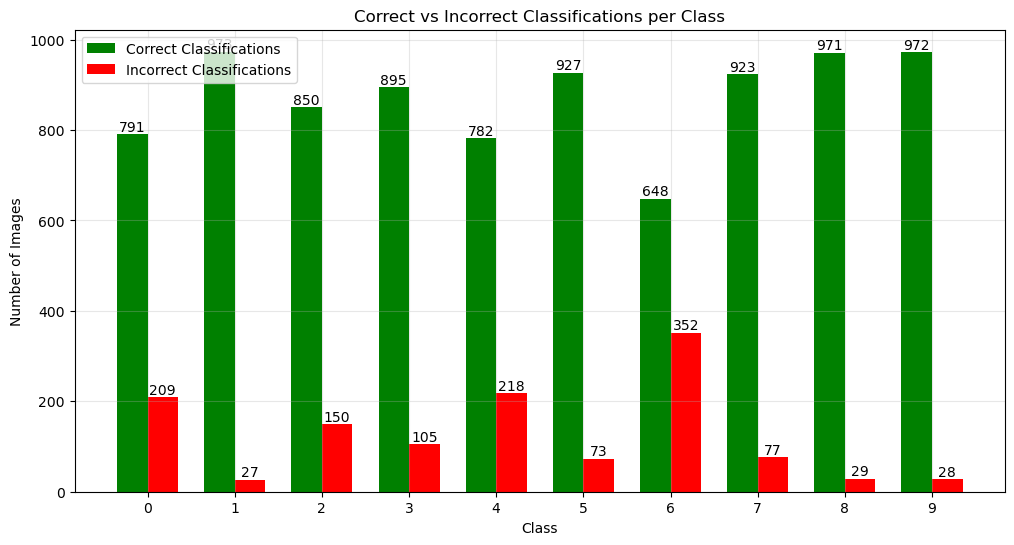


Accuracy per class:
Class 0: 79.10%
Class 1: 97.30%
Class 2: 85.00%
Class 3: 89.50%
Class 4: 78.20%
Class 5: 92.70%
Class 6: 64.80%
Class 7: 92.30%
Class 8: 97.10%
Class 9: 97.20%


In [90]:
# Calculate correct and incorrect classifications per class
class_results = {i: {'correct': 0, 'incorrect': 0} for i in range(10)}

# Go through all test data
for record, score in zip(test_data_list, scorecard):
    all_values = record.split(',')
    if len(all_values) != 785:  # Skip invalid records
        continue
        
    correct_label = int(all_values[0])
    if score == 1:
        class_results[correct_label]['correct'] += 1
    else:
        class_results[correct_label]['incorrect'] += 1

# Prepare data for plotting
classes = list(range(10))
correct_counts = [class_results[i]['correct'] for i in classes]
incorrect_counts = [class_results[i]['incorrect'] for i in classes]

# Create plot
plt.figure(figsize=(12, 6))
x = numpy.arange(len(classes))
width = 0.35

plt.bar(x - width/2, correct_counts, width, label='Correct Classifications', color='green')
plt.bar(x + width/2, incorrect_counts, width, label='Incorrect Classifications', color='red')

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Correct vs Incorrect Classifications per Class')
plt.xticks(x, classes)
plt.legend()

# Add value labels on top of each bar
for i, v in enumerate(correct_counts):
    plt.text(i - width/2, v, str(v), ha='center', va='bottom')
for i, v in enumerate(incorrect_counts):
    plt.text(i + width/2, v, str(v), ha='center', va='bottom')

plt.grid(True, alpha=0.3)
plt.show()

# Print accuracy per class
print("\nAccuracy per class:")
for i in classes:
    total = class_results[i]['correct'] + class_results[i]['incorrect']
    accuracy = class_results[i]['correct'] / total * 100 if total > 0 else 0
    print(f"Class {i}: {accuracy:.2f}%")